In [7]:
import pandas as pd, re, os
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

In [3]:
df = pd.read_excel('Kenya+protests+2025.xlsx')

In [9]:
if 'Author' in df.columns:
    df['author_clean'] = df['Author'].astype(str).fillna("unknown").str.strip().str.lower()
else:
    df['author_clean'] = ["unknown_%d" % i for i in range(len(df))]

In [11]:
mention_regex = re.compile(r'@([A-Za-z0-9_]+)')
rt_regex = re.compile(r'\bRT\s*@([A-Za-z0-9_]+)', re.IGNORECASE)

In [15]:
def extract_mentions_row(row):
    mentions = set()
    if 'Mentioned Authors' in df.columns and pd.notna(row.get('Mentioned Authors')):
        raw = str(row['Mentioned Authors'])
        parts = re.split(r'[,\;\|\/]+', raw)
        for p in parts:
            p = p.strip()
            if not p: continue
            if p.startswith('@'): p = p[1:]
            mentions.add(p.lower())
    txt = row.get('Full Text','') or ''
    for m in mention_regex.findall(str(txt)):
        mentions.add(m.lower())
    return list(mentions)

In [17]:
def extract_rts_row(row):
    targets = set()
    for col in df.columns:
        if 'repost' in col.lower() or 'retweet' in col.lower():
            val = row.get(col)
            if pd.notna(val):
                valstr = str(val)
                for m in mention_regex.findall(valstr):
                    targets.add(m.lower())
                # add raw if no @ (may be id/url); include for completeness
                s = valstr.strip().lower()
                if s and '@' not in s:
                    targets.add(s)
    txt = row.get('Full Text','') or ''
    for r in rt_regex.findall(str(txt)):
        targets.add(r.lower())
    return list(targets)

In [18]:
mention_edges = []
retweet_edges = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting edges"):
    src = row['author_clean']
    for m in extract_mentions_row(row):
        if m and src: mention_edges.append((src, m))
    for t in extract_rts_row(row):
        if t and src: retweet_edges.append((src, t))


Extracting edges: 100%|██████████| 49823/49823 [00:08<00:00, 5657.08it/s]


In [20]:
print("Extracted edges: mentions =", len(mention_edges), ", retweets =", len(retweet_edges))

Extracted edges: mentions = 53388 , retweets = 139709


In [21]:
Gm = nx.DiGraph()
for s,t in mention_edges:
    if Gm.has_edge(s,t): Gm[s][t]['weight'] += 1
    else: Gm.add_edge(s,t,weight=1, type='mention')

Gr = nx.DiGraph()
for s,t in retweet_edges:
    if Gr.has_edge(s,t): Gr[s][t]['weight'] += 1
    else: Gr.add_edge(s,t,weight=1, type='retweet')

In [22]:
print("Gm nodes,edges:", Gm.number_of_nodes(), Gm.number_of_edges())
print("Gr nodes,edges:", Gr.number_of_nodes(), Gr.number_of_edges())

Gm nodes,edges: 17512 49634
Gr nodes,edges: 25201 103016


In [23]:
def safe_metrics(G, name="graph"):
    n = G.number_of_nodes()
    print(f"Computing metrics for {name} (n={n}) ...")
    in_deg = dict(G.in_degree(weight='weight'))
    out_deg = dict(G.out_degree(weight='weight'))
    try:
        pr = nx.pagerank(G, weight='weight', alpha=0.85)
    except Exception as e:
        print("Pagerank error:", e)
        pr = {node: 0 for node in G.nodes()}

    if n > 1500:
        k = min(300, max(100, n//20))
        print("Large graph: using approximate betweenness with k=", k)
        bet = nx.betweenness_centrality(G, k=k, weight='weight', seed=42)
    else:
        bet = nx.betweenness_centrality(G, weight='weight')

    clu = nx.clustering(G.to_undirected()) if G.number_of_nodes()>0 else {}
    rows=[]
    for node in G.nodes():
        rows.append({
            "node": node,
            "in_degree": in_deg.get(node, 0),
            "out_degree": out_deg.get(node, 0),
            "pagerank": pr.get(node,0),
            "betweenness": bet.get(node,0),
            "clustering": clu.get(node,0)
        })
    return pd.DataFrame(rows).sort_values('pagerank', ascending=False).reset_index(drop=True)

mention_metrics = safe_metrics(Gm, "mentions")
retweet_metrics = safe_metrics(Gr, "retweets")

Computing metrics for mentions (n=17512) ...
Large graph: using approximate betweenness with k= 300
Computing metrics for retweets (n=25201) ...
Large graph: using approximate betweenness with k= 300


In [25]:
mention_metrics.to_csv("mention_network_metrics_corrected.csv", index=False)
retweet_metrics.to_csv("retweet_network_metrics_corrected.csv", index=False)
print("Saved metrics CSVs: mention_network_metrics_corrected.csv, retweet_network_metrics_corrected.csv")

Saved metrics CSVs: mention_network_metrics_corrected.csv, retweet_network_metrics_corrected.csv


In [27]:
print("\nTop 15 Mention network by PageRank:")
print(mention_metrics[['node','pagerank','in_degree']].head(15).to_string(index=False))


Top 15 Mention network by PageRank:
           node  pagerank  in_degree
      wakabando  0.030616        356
      _james041  0.019176       2784
    c_nyakundih  0.008740        970
        ngartia  0.008484        746
      iamrapcha  0.008380       1322
     fgaitho237  0.008230       1183
   williamsruto  0.007241        769
    itskipronoh  0.007057        876
sholard_mancity  0.006871        938
    wanjiru2027  0.005846        651
      nyandia_g  0.004665        693
      atwoliiya  0.004575        305
      propesatv  0.004565        144
   nickmuthumbi  0.004534        551
   honeyfarsafi  0.004152        598


In [28]:
print("\nTop 15 Mention network by In-degree:")
print(mention_metrics.sort_values('in_degree', ascending=False)[['node','in_degree','pagerank']].head(15).to_string(index=False))


Top 15 Mention network by In-degree:
           node  in_degree  pagerank
      _james041       2784  0.019176
      iamrapcha       1322  0.008380
     fgaitho237       1183  0.008230
    c_nyakundih        970  0.008740
sholard_mancity        938  0.006871
    itskipronoh        876  0.007057
   williamsruto        769  0.007241
        ngartia        746  0.008484
      nyandia_g        693  0.004665
    wanjiru2027        651  0.005846
   honeyfarsafi        598  0.004152
   migunamiguna        570  0.003700
   nickmuthumbi        551  0.004534
bobthebuil19383        544  0.003266
   wanjirunjira        539  0.003734


In [29]:
print("\nTop 15 Retweet network by PageRank:")
print(retweet_metrics[['node','pagerank','in_degree']].head(15).to_string(index=False))


Top 15 Retweet network by PageRank:
           node  pagerank  in_degree
              0  0.133895      48577
      _james041  0.004752       2612
              1  0.004342        534
     fgaitho237  0.002568       1137
      iamrapcha  0.002457       1302
    itskipronoh  0.002112        855
sholard_mancity  0.002081        925
    c_nyakundih  0.001932        795
        ngartia  0.001909        738
              2  0.001657        189
      nyandia_g  0.001399        688
      atwoliiya  0.001365        291
   nickmuthumbi  0.001357        549
   migunamiguna  0.001316        558
      mckennamk  0.001202        474


In [30]:
print("\nTop 15 Retweet network by In-degree:")
print(retweet_metrics.sort_values('in_degree', ascending=False)[['node','in_degree','pagerank']].head(15).to_string(index=False))


Top 15 Retweet network by In-degree:
           node  in_degree  pagerank
              0      48577  0.133895
      _james041       2612  0.004752
      iamrapcha       1302  0.002457
     fgaitho237       1137  0.002568
sholard_mancity        925  0.002081
    itskipronoh        855  0.002112
    c_nyakundih        795  0.001932
        ngartia        738  0.001909
      nyandia_g        688  0.001399
    wanjiru2027        622  0.001163
   migunamiguna        558  0.001316
   nickmuthumbi        549  0.001357
bobthebuil19383        535  0.000948
              1        534  0.004342
   wanjirunjira        506  0.000794


In [32]:
def plot_top_subgraph(G, metrics_df, title, fname, top_k=20):
    top_nodes = metrics_df.head(top_k)['node'].tolist()
    nodeset = set(top_nodes)
    for n in top_nodes:
        if n in G:
            nodeset.update(list(G.predecessors(n)))
            nodeset.update(list(G.successors(n)))
    SG = G.subgraph(nodeset).copy()
    print("Subgraph nodes,edges:", SG.number_of_nodes(), SG.number_of_edges())
    if SG.number_of_nodes()==0:
        print("No subgraph to plot.")
        return
    pos = nx.spring_layout(SG, k=0.5, seed=42)
    pr_map = metrics_df.set_index('node')['pagerank'].to_dict()
    in_map = metrics_df.set_index('node')['in_degree'].to_dict()
    node_sizes = [(pr_map.get(n,0)*8000)+50 for n in SG.nodes()]
    max_in = max(in_map.values()) if len(in_map)>0 else 1
    node_colors = [ in_map.get(n,0)/max_in for n in SG.nodes() ]
    plt.figure(figsize=(12,12))
    nodes = nx.draw_networkx_nodes(SG, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis, alpha=0.9)
    nx.draw_networkx_edges(SG, pos, alpha=0.3, width=0.6)
    labels = {n:n for n in metrics_df.head(25)['node'] if n in SG.nodes()}
    nx.draw_networkx_labels(SG, pos, labels=labels, font_size=9)
    plt.title(title)
    plt.colorbar(nodes, label='Normalized in-degree')
    plt.axis('off')
    plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()

Subgraph nodes,edges: 7115 18386


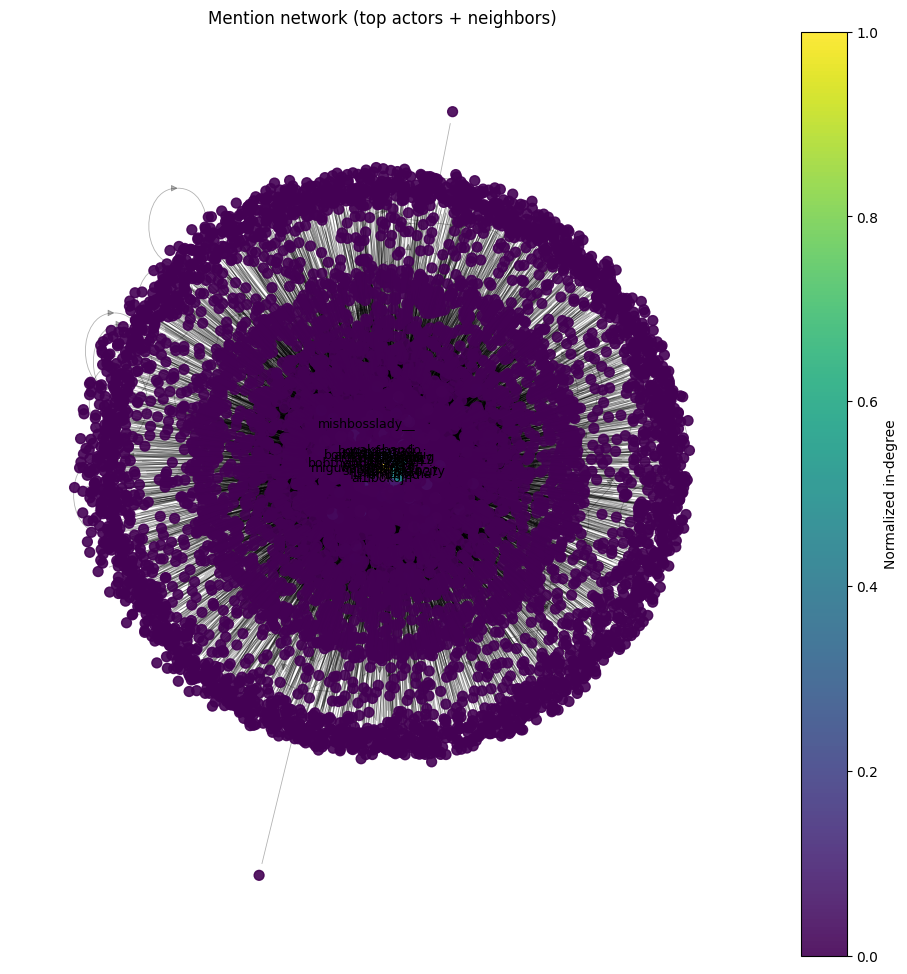

Subgraph nodes,edges: 15643 38645


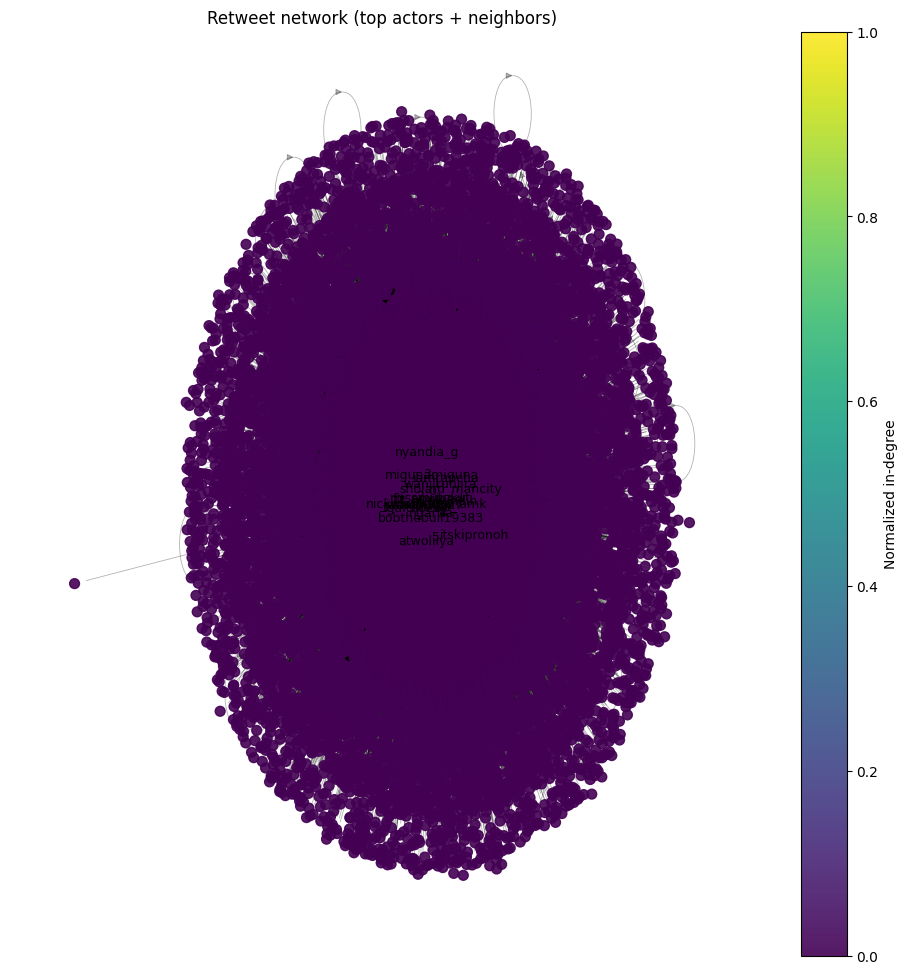

In [33]:
plot_top_subgraph(Gm, mention_metrics, "Mention network (top actors + neighbors)", "mention_subgraph_corrected.png", top_k=20)
plot_top_subgraph(Gr, retweet_metrics, "Retweet network (top actors + neighbors)", "retweet_subgraph_corrected.png", top_k=20)

Across both the mention and retweet networks, visibility and influence in the June 2025 Kenyan protest discourse are shaped by a small cluster of hyper-central actors who dominate attention flows. The top nodes in the mention network — such as _james041, iamrapcha, fgaitho237, c_nyakundih, and ngartia — receive extremely high in-degree values, indicating that thousands of users referenced them directly. This pattern suggests that these accounts were central narrators or coordinators of the protest conversation. Their visibility stems not from institutional authority but from being embedded in activist, youth, or commentary communities that organically amplify each other.

The retweet network reinforces this structure: again _james041, iamrapcha, and fgaitho237 occupy top positions, showing that protest mobilisation was propelled by the circulation of a small set of influential messages. The presence of large hub nodes with extremely high in-degree (e.g., 48,577 retweets into node "0") indicates a broadcast-style diffusion pattern: one post or actor captured massive attention and acted as a mobilisation catalyst. This resembles “flashpoint” mobilisation, where a single narrative becomes a coordination anchor during crisis moments.

Coalitions emerge through clusters around activist commentators, political influencers, and citizen journalists. The same names appear in both mention and retweet rankings, suggesting overlapping echo chambers where users both reference and amplify the same actors. This tight coupling often accelerates mobilisation but reduces narrative diversity.

Platform affordances and inequalities shape whose voices become central. Users with high follower counts, verified status, media literacy, or established activist reputations gain disproportionate visibility. Language choices (English vs. Sheng/Kiswahili), device connectivity, and data affordability further concentrate influence among urban, digitally fluent users. Meanwhile, rural or marginalised voices — despite experiencing the protest impacts most directly — remain structurally peripheral.

Overall, the networks reveal a protest conversation dominated by a small, highly amplified influencer-core whose narratives shaped coordination rhythms, sentiment, and how events were interpreted in real time.

##Question 2

In [39]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from collections import Counter

In [35]:
df['Date_parsed'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
df = df.dropna(subset=['Date_parsed']).copy()
df['Date_only'] = df['Date_parsed'].dt.date

In [36]:
agg = df.groupby('Date_only').size().reset_index(name='count')
agg = agg.sort_values('Date_only')
agg['count_ma7'] = agg['count'].rolling(window=7, min_periods=1, center=True).mean()

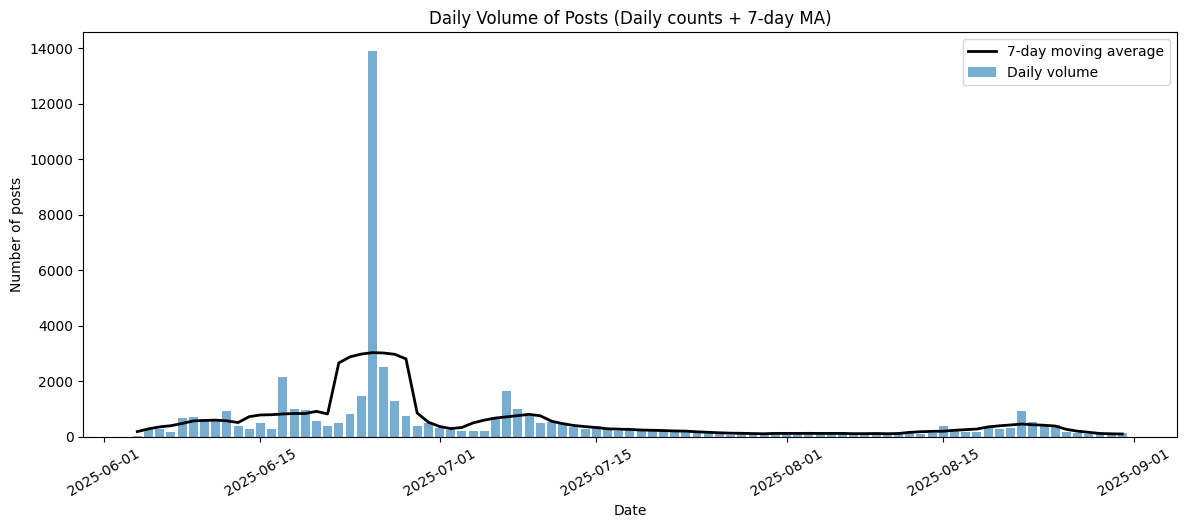

In [40]:
plt.figure(figsize=(12,5))
plt.bar(agg['Date_only'], agg['count'], alpha=0.6, label='Daily volume')
plt.plot(agg['Date_only'], agg['count_ma7'], color='black', linewidth=2, label='7-day moving average')
plt.title('Daily Volume of Posts (Daily counts + 7-day MA)')
plt.xlabel('Date')
plt.ylabel('Number of posts')
plt.legend()
plt.tight_layout()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=30)
plt.savefig("time_series_volume_ma7.png", dpi=300)
plt.show()

In [41]:
sent_daily = df.groupby(['Date_only', 'Sentiment']).size().reset_index(name='count')

In [42]:
sent_pivot = sent_daily.pivot(index='Date_only', columns='Sentiment', values='count').fillna(0)


In [43]:
for c in ['positive','neutral','negative']:
    if c not in sent_pivot.columns:
        sent_pivot[c] = 0
sent_pivot = sent_pivot.sort_index()

In [44]:
sent_ma = sent_pivot.rolling(window=7, min_periods=1, center=True).mean()

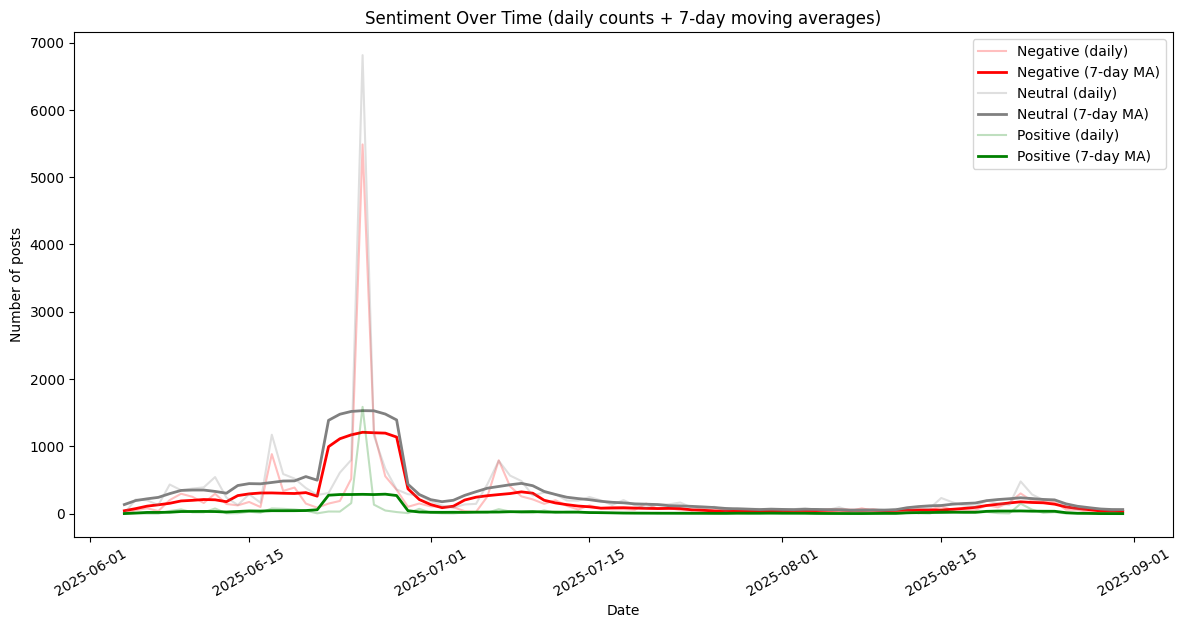

In [45]:
plt.figure(figsize=(12,6))
plt.plot(sent_pivot.index, sent_pivot['negative'], label='Negative (daily)', alpha=0.25, color='red')
plt.plot(sent_ma.index, sent_ma['negative'], label='Negative (7-day MA)', color='red', linewidth=2)
plt.plot(sent_pivot.index, sent_pivot['neutral'], label='Neutral (daily)', alpha=0.25, color='gray')
plt.plot(sent_ma.index, sent_ma['neutral'], label='Neutral (7-day MA)', color='gray', linewidth=2)
plt.plot(sent_pivot.index, sent_pivot['positive'], label='Positive (daily)', alpha=0.25, color='green')
plt.plot(sent_ma.index, sent_ma['positive'], label='Positive (7-day MA)', color='green', linewidth=2)
plt.title('Sentiment Over Time (daily counts + 7-day moving averages)')
plt.xlabel('Date')
plt.ylabel('Number of posts')
plt.legend()
plt.tight_layout()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=30)
plt.savefig("sentiment_time_series_ma7.png", dpi=300)
plt.show()

In [46]:
top_days = agg.sort_values('count', ascending=False).head(10)
print("Top volume days:\n", top_days)

Top volume days:
      Date_only  count    count_ma7
21  2025-06-25  13888  3027.571429
22  2025-06-26   2503  3014.857143
13  2025-06-17   2136   816.000000
33  2025-07-07   1646   712.142857
20  2025-06-24   1474  2975.285714
23  2025-06-27   1272  2967.571429
34  2025-07-08   1003   757.571429
14  2025-06-18    999   832.142857
15  2025-06-19    973   831.571429
79  2025-08-22    928   452.857143


In [47]:
def top_terms_on_date(date, topn=10):
    rows = df[df['Date_only'] == date]
    # prefer Hashtags column if present
    if 'Hashtags' in df.columns:
        # Hashtags may be a string with comma-separated items; handle nulls
        tags = rows['Hashtags'].dropna().astype(str).str.split(',').explode().str.strip().str.lower()
        tags = tags[tags != '']
        return Counter(tags).most_common(topn)
    else:
        # fallback: token frequency in Cleaned_Tweet (if available)
        if 'Cleaned_Tweet' in df.columns:
            words = rows['Cleaned_Tweet'].dropna().astype(str).str.split().explode()
            words = words[~words.str.startswith('#')]  # optionally exclude hashtags
            words = words.dropna().str.lower()
            return Counter(words).most_common(topn)
        else:
            return []

In [48]:
print("\nPeaks and top terms on those days:")
for d in top_days['Date_only'].tolist():
    print("\nDate:", d)
    print("Top terms or hashtags:", top_terms_on_date(d, topn=8))


Peaks and top terms on those days:

Date: 2025-06-25
Top terms or hashtags: [('#rutomustgo', 12633), ('#sirininumbers', 7608), ('#occupystatehouse2025', 1706), ('#june25th', 1251), ('#rutomustgonow', 753), ('#occupyuntilvictory', 646), ('#occupystatehouse', 633), ('#justice4ourmashujaa', 301)]

Date: 2025-06-26
Top terms or hashtags: [('#rutomustgo', 1925), ('#sirininumbers', 1026), ('#june25th', 169), ('#occupystatehouse2025', 168), ('#occupyuntilvictory', 123), ('#endpolicebrutalityke', 115), ('#25thjune2025', 99), ('#rutomustgonow', 45)]

Date: 2025-06-17
Top terms or hashtags: [('#rutomustgo', 1605), ('#justiceforalbertojwang', 494), ('#endpolicebrutalityke', 250), ('#tuesdaymaandamano', 235), ('#arresteliudlagat', 200), ('#fufuaicc', 185), ('#justiceforalbertochieng', 126), ('#justiceforelijoshua', 109)]

Date: 2025-07-07
Top terms or hashtags: [('#rutomustgo', 1385), ('#sabasaba2025', 401), ('#77ninumbers', 362), ('#sirininumbers', 227), ('#sabasabarevolutionday', 224), ('#occup

The protest conversation unfolds in distinct emotional waves, tightly mapped to offline mobilisation and platform reactions. Daily volume and sentiment trends show that the discourse does not move linearly; instead, it accelerates and collapses in sharp pulses, reflecting the unstable rhythms of protest organisation in a constrained digital environment.

The largest spike appears on 25 June, where conversation volume surges to nearly 14,000 posts. This coincides with the #RutoMustGo, #SiriNiNumbers, and #OccupyStateHouse2025 campaigns dominating the platform. At this point, negative sentiment reaches its peak. Rather than being a gradual rise, this is a sudden eruption — indicating a shift from dispersed anger to coordinated mobilisation. This is typical of Global South digital activism, where organisation often occurs rapidly through hashtag cascades, not long-term planning.

After 26 June, both volume and negative sentiment collapse almost immediately. This “burnout curve” reveals a core characteristic of mobilisation under constraint: momentary bursts of intensity followed by steep drop-offs, driven by censorship fears, data costs, and emotional exhaustion. Protest energy is therefore episodic, not continuous.

Earlier micro-peaks (17–19 June) align with police brutality incidents and justice hashtags (#JusticeForAlbertoJwang, #EndPoliceBrutalityKE). These represent moral shocks — sudden emotional events that re-ignite network activity. Later spikes (7–8 July, #SabaSaba2025) indicate symbolic, calendar-driven mobilisation, showing how Kenyan protest culture blends spontaneous outrage with historically anchored protest days.

Topic drift also follows this emotional cycle: from police killings → statehouse occupation call → Saba Saba revival → anti-Ruto consolidation. Themes converge toward a singular narrative during peak mobilisation but fragment again once the moment passes.

Methodologically, sentiment-over-time captures emotional escalation very well but oversimplifies nuance (e.g., sarcasm, multilingual posts). Hashtag frequency reveals mobilisation triggers, but platform bias (X dominating the dataset) means the analysis reflects one platform’s rhythm, not the entire ecosystem.